# Claims prediction with the RoBERTa classifier used in the Coan et al. (2021) article 'Computer-assisted detection and classification of misinformation about climate change

In [1]:
## Author: Mirjam Nanko
## Date Created: 2021-02-01
## Email: m.nanko@exeter.ac.uk

## Setup

In [2]:
# Load the required packages

# Dataframes
import pandas as pd

# Regular expressions
import re

# Unidecoder
import unicodedata

# Timestamp / time measurment
import time

# Simpletransformers classifier
from simpletransformers.classification import ClassificationModel

# Softmax function for predicted probabiliy calculation
from scipy.special import softmax

# PyTorch: enable GPU access
import torch

# If you want to select a specific GPU, set it here:
# gpu = 0
# torch.cuda.set_device(gpu) 

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use GPU {}:'.format(torch.cuda.current_device()), torch.cuda.get_device_name(torch.cuda.current_device()))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image 

There are 1 GPU(s) available.
We will use GPU 0: NVIDIA GeForce GTX 1080 Ti


In [3]:
# Define required functions
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Assuming 'sample' is your pandas Series containing text data

# Preprocessing function
def denoise_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    text  =  re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'_+', ' ', text)
    text =re.sub(r'\s{2,}', ' ', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return words

## Data Preparation

In [4]:
# Load the text data
data = pd.read_csv('/home/users/mhossain/data/pub_texts.csv')
print('{} paragraphs were loaded. Here are the first few rows of the data:'.format(len(data)))
data.head()

405033 paragraphs were loaded. Here are the first few rows of the data:


,pub_text
0,"Yes, EV:s are happening. I would agree with yo..."
1,"It's not news, but it is very much part of a m..."
2,\nClimate change has a variety of consequences...
3,No clue. Cultural change is difficult and slow...
4,Then how do you bring up the issue of climate ...


In [5]:
# Pre-process the text
data['text_denoised'] = data['pub_text'].astype(str).apply(denoise_text)

In [6]:
print('{} paragraphs were loaded. Here are the first few rows of the data:'.format(len(data)))

405033 paragraphs were loaded. Here are the first few rows of the data:


In [7]:
data = data.drop_duplicates()
data

,pub_text,text_denoised
0,"Yes, EV:s are happening. I would agree with yo...",yes ev happening would agree one normal ev car...
1,"It's not news, but it is very much part of a m...",news much part measure news based subreddit hi...
2,\nClimate change has a variety of consequences...,climate change variety consequence perfect exa...
3,No clue. Cultural change is difficult and slow...,clue cultural change difficult slow effect kno...
4,Then how do you bring up the issue of climate ...,bring issue climate change one acknowledge exi...
...,...,...
405027,<title> The chairman of the Intergovernmental ...,title chairman intergovernmental panel climate...
405028,<title> World Leaders on Climate Change 2<text...,title world leader climate change text removed
405029,<title> This desperate problem which is being ...,title desperate problem largely ignored moment...
405031,<title> Feeling the Heat: Climate Change Has B...,title feeling heat climate change become reali...


In [8]:
data = data.dropna()
data

,pub_text,text_denoised
0,"Yes, EV:s are happening. I would agree with yo...",yes ev happening would agree one normal ev car...
1,"It's not news, but it is very much part of a m...",news much part measure news based subreddit hi...
2,\nClimate change has a variety of consequences...,climate change variety consequence perfect exa...
3,No clue. Cultural change is difficult and slow...,clue cultural change difficult slow effect kno...
4,Then how do you bring up the issue of climate ...,bring issue climate change one acknowledge exi...
...,...,...
405027,<title> The chairman of the Intergovernmental ...,title chairman intergovernmental panel climate...
405028,<title> World Leaders on Climate Change 2<text...,title world leader climate change text removed
405029,<title> This desperate problem which is being ...,title desperate problem largely ignored moment...
405031,<title> Feeling the Heat: Climate Change Has B...,title feeling heat climate change become reali...


In [9]:
data_sample = data[:50000]

In [10]:
data_sample

,pub_text,text_denoised
0,"Yes, EV:s are happening. I would agree with yo...",yes ev happening would agree one normal ev car...
1,"It's not news, but it is very much part of a m...",news much part measure news based subreddit hi...
2,\nClimate change has a variety of consequences...,climate change variety consequence perfect exa...
3,No clue. Cultural change is difficult and slow...,clue cultural change difficult slow effect kno...
4,Then how do you bring up the issue of climate ...,bring issue climate change one acknowledge exi...
...,...,...
51332,"&gt; Name three species, not sub-species like ...",gt name three specie subspecies like shortyell...
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...
51334,"Okay, I wasn't going to answer you at all, but...",okay wasnt going answer ive changed mind diffi...
51335,&gt;Extinction of species is harm in the eyes ...,gtextinction specie harm eye educated people e...


## Predict text labels (claims) with the pre-trained RoBERTa classifier used in the Coan et al. (2021) article

In [11]:
%%time
# Define the model 
architecture = 'roberta'
model_name = '/home/users/mhossain/project/models/CARDS_RoBERTa_Classifier'

# Load the classifier
model = ClassificationModel(architecture, model_name)

# Predict the labels
predictions, raw_outputs = model.predict(list(data_sample.text_denoised))

Some weights of the model checkpoint at /home/users/mhossain/project/models/CARDS_RoBERTa_Classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/50000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

  0%|          | 0/7279 [00:00<?, ?it/s]

CPU times: user 26min 46s, sys: 11.2 s, total: 26min 57s
Wall time: 27min 18s


In [12]:
# Join predictions to the data
data_sample['RoBERTa_pred_label'] = predictions
data_sample['RoBERTa_pred_probabilities'] = [softmax(element[0]) for element in raw_outputs]

data_sample.head()

/tmp/ipykernel_394216/3749265118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample['RoBERTa_pred_label'] = predictions
/tmp/ipykernel_394216/3749265118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample['RoBERTa_pred_probabilities'] = [softmax(element[0]) for element in raw_outputs]


,pub_text,text_denoised,RoBERTa_pred_label,RoBERTa_pred_probabilities
0,"Yes, EV:s are happening. I would agree with yo...",yes ev happening would agree one normal ev car...,0,"[0.9987357516513675, 1.0907393066272357e-05, 7..."
1,"It's not news, but it is very much part of a m...",news much part measure news based subreddit hi...,0,"[0.9997907048408721, 5.244071056673041e-06, 1...."
2,\nClimate change has a variety of consequences...,climate change variety consequence perfect exa...,0,"[0.9985436196886541, 8.754097409202874e-06, 5...."
3,No clue. Cultural change is difficult and slow...,clue cultural change difficult slow effect kno...,0,"[0.9996052618870238, 4.359434313885414e-06, 2...."
4,Then how do you bring up the issue of climate ...,bring issue climate change one acknowledge exi...,0,"[0.9997376158144453, 5.238674204180221e-06, 2...."


In [13]:
data_sample.loc[81,'text_denoised']

'gt economic growth decoupled rising carbon emission developed country decade fiction created accounting trick developed country didnt create magic trick decouple growing economy rising emission sent factory overseas emission factory dont count country significant shipping emission arent counted either look global picture see decoupled economic growth emission two strongly correlated global level mean reducing emission require steadystate shrinking economy either mean shrinking population lowering standard living also carbon capture serious approach climate change idea make feasible scale would actually make impact scale level would many many negative effect environment'

In [14]:
data_sample.loc[49984,'text_denoised']

'source common denialist talking point sadly obscures pretty fundamental concept climate paleoclimate numerous instance co increase preceding warming paleoclimatic record however ice core record transition appears though co lag increase temperature say appears temporal resolution proxy analysis showed apparent effect pretty poor hundred year uncertainty existence lag unexpected driver change ice core record milankovitchorbital forcing precipitated warming engaged positive feedback among carbon cycle presence lag present problem mainstream scientific understanding climatecarbon relationship indeed scientist anticipated large lag ky imagining sluggish carbon cycle responding slowly change induced orbital variation temperature data used claiming existence lag global however rather taken antarctic interior trusted correlated change global mean long timescales contrast co ice core le treated indicative global mean due well mixed nature even short timescales behavior global temperature light

In [15]:
data_sample = data_sample.drop(columns='RoBERTa_pred_probabilities')

In [16]:
data_sample

,pub_text,text_denoised,RoBERTa_pred_label
0,"Yes, EV:s are happening. I would agree with yo...",yes ev happening would agree one normal ev car...,0
1,"It's not news, but it is very much part of a m...",news much part measure news based subreddit hi...,0
2,\nClimate change has a variety of consequences...,climate change variety consequence perfect exa...,0
3,No clue. Cultural change is difficult and slow...,clue cultural change difficult slow effect kno...,0
4,Then how do you bring up the issue of climate ...,bring issue climate change one acknowledge exi...,0
...,...,...,...
51332,"&gt; Name three species, not sub-species like ...",gt name three specie subspecies like shortyell...,0
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,7
51334,"Okay, I wasn't going to answer you at all, but...",okay wasnt going answer ive changed mind diffi...,17
51335,&gt;Extinction of species is harm in the eyes ...,gtextinction specie harm eye educated people e...,0


### Map the predicted label with the corresponding claim according to the base paper

In [17]:
label_to_claim = {
    0: 'No Claim',
    1: 'Ice/permafrost/snow cover is not melting',
    2: 'We are heading into an ice age/global cooling',
    3: 'Weather is cold/snowing',
    4: 'Climate has not warmed/changed over the last (few) decades',
    5: 'Sea level rise is exaggerated/not accelerating',
    6: 'Extreme weather is not increasing/has happened before/is not linked to climate change',
    7: 'It is natural cycles/variation',
    8: 'There is no evidence for greenhouse effect/carbon dioxide driving climate change',
    9: 'Climate sensitivity is low/negative feedbacks reduce warming',
    10: 'Species/plants/reefs are not showing climate impacts/are benefiting from climate change',
    11: 'CO2 is beneficial/not a pollutant',
    12: 'Climate policies (mitigation or adaptation) are harmful',
    13: 'Climate policies are effective/flawed',
    14: 'Clean energy technology/biofuels won’t work',
    15: 'People need energy (e.g. from fossil fuels/nuclear)',
    16: 'Climate-related science is unreliable/uncertain/unsound (data and methods and models)',
    17: 'Climate movement is unreliable/alarmist/corrupt'
}

# Apply the mapping to create a new column with the mapped claim
data_sample['Mapped_Claim'] = data_sample['RoBERTa_pred_label'].map(label_to_claim)

In [18]:
data_sample

,pub_text,text_denoised,RoBERTa_pred_label,Mapped_Claim
0,"Yes, EV:s are happening. I would agree with yo...",yes ev happening would agree one normal ev car...,0,No Claim
1,"It's not news, but it is very much part of a m...",news much part measure news based subreddit hi...,0,No Claim
2,\nClimate change has a variety of consequences...,climate change variety consequence perfect exa...,0,No Claim
3,No clue. Cultural change is difficult and slow...,clue cultural change difficult slow effect kno...,0,No Claim
4,Then how do you bring up the issue of climate ...,bring issue climate change one acknowledge exi...,0,No Claim
...,...,...,...,...
51332,"&gt; Name three species, not sub-species like ...",gt name three specie subspecies like shortyell...,0,No Claim
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,7,It is natural cycles/variation
51334,"Okay, I wasn't going to answer you at all, but...",okay wasnt going answer ive changed mind diffi...,17,Climate movement is unreliable/alarmist/corrupt
51335,&gt;Extinction of species is harm in the eyes ...,gtextinction specie harm eye educated people e...,0,No Claim


In [19]:
#data_sample.to_csv('reddit_model_label.csv', index=False)

In [20]:
data_sample['RoBERTa_pred_label'].unique()

array([ 0,  7, 10, 14, 12, 17,  8, 13, 15, 11, 16,  1,  2,  9,  6,  5,  4,
        3])

In [21]:
data_sample= data_sample[data_sample['RoBERTa_pred_label']!=0]

In [22]:
data_sample

,pub_text,text_denoised,RoBERTa_pred_label,Mapped_Claim
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,7,It is natural cycles/variation
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,10,Species/plants/reefs are not showing climate i...
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,14,Clean energy technology/biofuels won’t work
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,12,Climate policies (mitigation or adaptation) ar...
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,14,Clean energy technology/biofuels won’t work
...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,17,Climate movement is unreliable/alarmist/corrupt
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,17,Climate movement is unreliable/alarmist/corrupt
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,17,Climate movement is unreliable/alarmist/corrupt
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,7,It is natural cycles/variation


In [23]:
data_sample.to_csv('model_label_claim.csv', index=False)

### Topic modeling

In [53]:
lda_tm = data_sample[['text_denoised']]
lda_tm

,text_denoised
41,climate also effected natural effect like sola...
53,reading article earlier team australia able sp...
65,renewables mix wind remains par nuclear data p...
81,gt economic growth decoupled rising carbon emi...
82,windfarms solar effective large area case spac...
...,...
51324,term climate change always arround think find ...
51329,gt part article think james delingpole doesnt ...
51331,like rude version global warmingclimate change...
51333,gtkulke writes coscience explaining climate ch...


In [48]:
#lda_tm = pd.read_csv("/home/users/mhossain/projects/cards/fit/roberta/text_denoised.csv")

In [57]:
type(lda_tm)

pandas.core.frame.DataFrame

In [58]:
type(lda_tm['text_denoised'])

pandas.core.series.Series

 ### Convert Text to Document-Term Matrix

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(lda_tm['text_denoised'])

# Display the shape of the document-term matrix
print(doc_term_matrix.shape)

(13991, 20222)


In [60]:
doc_term_matrix

<13991x20222 sparse matrix of type '<class 'numpy.int64'>'
	with 840133 stored elements in Compressed Sparse Row format>

### Apply LDA Topic Modeling

In [61]:
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics you want to identify
num_topics = 17

# Initialize the LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the LDA model to the document-term matrix
lda.fit(doc_term_matrix)

# Display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
people alarmist gore al world hoax greta medium like scientist
Topic 1:
data temperature model year warming record science time station global
Topic 2:
atmosphere temperature water greenhouse effect gas earth heat energy increase
Topic 3:
consensus scientist warming claim study global human say scientific evidence
Topic 4:
energy power nuclear fuel wind solar fossil plant coal country
Topic 5:
level sea rise ice year ocean rising rate plant gt
Topic 6:
think gt people ampxb dont question thing model say science
Topic 7:
gt warming temperature model year feedback increase sensitivity estimate effect
Topic 8:
science political gt global people agenda scientist public alarmism warming
Topic 9:
year warming global time earth alarmist human like ago people
Topic 10:
people money fuel world fossil government oil like dont problem
Topic 11:
ice age temperature period warming ec solar new core little
Topic 12:
emission carbon global year cost policy economic tax cut ipcc
Topic 13:
war

### Assign Topics to Documents

In [62]:
# Transform the document-term matrix to get the topic distribution for each document
topic_distribution = lda.transform(doc_term_matrix)

# Assign the most probable topic to each document
lda_tm['topic'] = topic_distribution.argmax(axis=1)

# Display the first few rows to check the assigned topics
lda_tm[['text_denoised', 'topic']]


/tmp/ipykernel_394216/3306766154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_tm['topic'] = topic_distribution.argmax(axis=1)


,text_denoised,topic
41,climate also effected natural effect like sola...,14
53,reading article earlier team australia able sp...,5
65,renewables mix wind remains par nuclear data p...,4
81,gt economic growth decoupled rising carbon emi...,12
82,windfarms solar effective large area case spac...,4
...,...,...
51324,term climate change always arround think find ...,16
51329,gt part article think james delingpole doesnt ...,7
51331,like rude version global warmingclimate change...,16
51333,gtkulke writes coscience explaining climate ch...,13


In [63]:
lda_tm.topic.unique()

array([14,  5,  4, 12,  9,  2,  8, 10, 15,  6, 16,  1,  7, 13,  0,  3, 11])

In [64]:
label_to_topic = {
0: "Climate Change Alarmism and Public Figures",
1: "Global Temperature Records and Climate Data",
2: "Greenhouse Effect and Atmospheric Science",
3: "Scientific Consensus on Climate Change",
4: "Energy Sources and Their Impact on Climate",
5: "Sea Level Rise and Oceanic Changes",
6: "Public Opinion and Climate Change Beliefs",
7: "Climate Sensitivity and Feedback Mechanisms",
8: " Climate Science and Public Discourse",
9: "Historical Perspectives on Global Warming",
10: "Fossil Fuels, Government Policy, and Economic Impact",
11: "Ice Ages and Historical Climate Patterns",
12: "Carbon Emissions and Economic Policy",
13: "Solar Influence on Climate and Natural Variability",
14: "Extreme Weather Events and Climate Change",
15: "Skepticism and Beliefs about Climate Science",
16: "Scientific Research and Climate Change Publications",
}

# Apply the mapping to create a new column with the mapped claim
lda_tm['Mapped_Topic'] = lda_tm['topic'].map(label_to_topic)

/tmp/ipykernel_394216/1999576027.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_tm['Mapped_Topic'] = lda_tm['topic'].map(label_to_topic)


In [65]:
lda_tm

,text_denoised,topic,Mapped_Topic
41,climate also effected natural effect like sola...,14,Extreme Weather Events and Climate Change
53,reading article earlier team australia able sp...,5,Sea Level Rise and Oceanic Changes
65,renewables mix wind remains par nuclear data p...,4,Energy Sources and Their Impact on Climate
81,gt economic growth decoupled rising carbon emi...,12,Carbon Emissions and Economic Policy
82,windfarms solar effective large area case spac...,4,Energy Sources and Their Impact on Climate
...,...,...,...
51324,term climate change always arround think find ...,16,Scientific Research and Climate Change Publica...
51329,gt part article think james delingpole doesnt ...,7,Climate Sensitivity and Feedback Mechanisms
51331,like rude version global warmingclimate change...,16,Scientific Research and Climate Change Publica...
51333,gtkulke writes coscience explaining climate ch...,13,Solar Influence on Climate and Natural Variabi...


In [66]:
type(lda_tm)

pandas.core.frame.DataFrame

In [67]:
# Direct comparison
are_equal = lda_tm['text_denoised'].equals(data_sample['text_denoised'])

print(f"Are the columns identical? {are_equal}")

Are the columns identical? True


In [68]:
# Direct comparison
are_equal = set(lda_tm['text_denoised']) == set(data_sample['text_denoised'])

print(f"Are the columns identical? {are_equal}")

Are the columns identical? True


In [69]:
lda_tm['text_denoised']

41       climate also effected natural effect like sola...
53       reading article earlier team australia able sp...
65       renewables mix wind remains par nuclear data p...
81       gt economic growth decoupled rising carbon emi...
82       windfarms solar effective large area case spac...
                               ...                        
51324    term climate change always arround think find ...
51329    gt part article think james delingpole doesnt ...
51331    like rude version global warmingclimate change...
51333    gtkulke writes coscience explaining climate ch...
51334    okay wasnt going answer ive changed mind diffi...
Name: text_denoised, Length: 13991, dtype: object

In [70]:
data_sample['text_denoised']

41       climate also effected natural effect like sola...
53       reading article earlier team australia able sp...
65       renewables mix wind remains par nuclear data p...
81       gt economic growth decoupled rising carbon emi...
82       windfarms solar effective large area case spac...
                               ...                        
51324    term climate change always arround think find ...
51329    gt part article think james delingpole doesnt ...
51331    like rude version global warmingclimate change...
51333    gtkulke writes coscience explaining climate ch...
51334    okay wasnt going answer ive changed mind diffi...
Name: text_denoised, Length: 13991, dtype: object

In [71]:
data_sample

,pub_text,text_denoised,RoBERTa_pred_label,Mapped_Claim
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,7,It is natural cycles/variation
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,10,Species/plants/reefs are not showing climate i...
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,14,Clean energy technology/biofuels won’t work
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,12,Climate policies (mitigation or adaptation) ar...
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,14,Clean energy technology/biofuels won’t work
...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,17,Climate movement is unreliable/alarmist/corrupt
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,17,Climate movement is unreliable/alarmist/corrupt
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,17,Climate movement is unreliable/alarmist/corrupt
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,7,It is natural cycles/variation


In [72]:
lda_tm

,text_denoised,topic,Mapped_Topic
41,climate also effected natural effect like sola...,14,Extreme Weather Events and Climate Change
53,reading article earlier team australia able sp...,5,Sea Level Rise and Oceanic Changes
65,renewables mix wind remains par nuclear data p...,4,Energy Sources and Their Impact on Climate
81,gt economic growth decoupled rising carbon emi...,12,Carbon Emissions and Economic Policy
82,windfarms solar effective large area case spac...,4,Energy Sources and Their Impact on Climate
...,...,...,...
51324,term climate change always arround think find ...,16,Scientific Research and Climate Change Publica...
51329,gt part article think james delingpole doesnt ...,7,Climate Sensitivity and Feedback Mechanisms
51331,like rude version global warmingclimate change...,16,Scientific Research and Climate Change Publica...
51333,gtkulke writes coscience explaining climate ch...,13,Solar Influence on Climate and Natural Variabi...


In [73]:
# Select specific columns from the first DataFrame
selected_columns_df1 = data_sample[['pub_text', 'text_denoised','Mapped_Claim',]]  # Replace with actual column names

# Select specific columns from the second DataFrame
selected_columns_df2 = lda_tm[['text_denoised', 'Mapped_Topic']]  # Replace with actual column names


In [74]:
# Combine columns from df1 and df2 side by side
final_df = pd.concat([selected_columns_df1, selected_columns_df2], axis=1)
final_df

,pub_text,text_denoised,Mapped_Claim,text_denoised,Mapped_Topic
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,It is natural cycles/variation,climate also effected natural effect like sola...,Extreme Weather Events and Climate Change
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,Species/plants/reefs are not showing climate i...,reading article earlier team australia able sp...,Sea Level Rise and Oceanic Changes
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,Clean energy technology/biofuels won’t work,renewables mix wind remains par nuclear data p...,Energy Sources and Their Impact on Climate
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,Climate policies (mitigation or adaptation) ar...,gt economic growth decoupled rising carbon emi...,Carbon Emissions and Economic Policy
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,Clean energy technology/biofuels won’t work,windfarms solar effective large area case spac...,Energy Sources and Their Impact on Climate
...,...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,Climate movement is unreliable/alarmist/corrupt,term climate change always arround think find ...,Scientific Research and Climate Change Publica...
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,Climate movement is unreliable/alarmist/corrupt,gt part article think james delingpole doesnt ...,Climate Sensitivity and Feedback Mechanisms
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,Climate movement is unreliable/alarmist/corrupt,like rude version global warmingclimate change...,Scientific Research and Climate Change Publica...
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,It is natural cycles/variation,gtkulke writes coscience explaining climate ch...,Solar Influence on Climate and Natural Variabi...


In [75]:
final_df = final_df.loc[:,~final_df.columns.duplicated()]
final_df

,pub_text,text_denoised,Mapped_Claim,Mapped_Topic
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,It is natural cycles/variation,Extreme Weather Events and Climate Change
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,Species/plants/reefs are not showing climate i...,Sea Level Rise and Oceanic Changes
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,Climate policies (mitigation or adaptation) ar...,Carbon Emissions and Economic Policy
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate
...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,Climate movement is unreliable/alarmist/corrupt,Climate Sensitivity and Feedback Mechanisms
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,It is natural cycles/variation,Solar Influence on Climate and Natural Variabi...


### TF-IDF Cosine Similarity
TF-IDF (Term Frequency-Inverse Document Frequency) is a common method for converting text to vectors and then calculating cosine similarity.

In [76]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assume final_df is your DataFrame with 'Mapped_Claim' and 'Mapped_Topic'

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'Mapped_Claim' and 'Mapped_Topic' columns
claim_tfidf = vectorizer.fit_transform(final_df['Mapped_Claim'])
topic_tfidf = vectorizer.transform(final_df['Mapped_Topic'])

# Calculate cosine similarity for each row
cos_sim_tfidf = cosine_similarity(claim_tfidf, topic_tfidf).diagonal()

# Add the cosine similarity to the DataFrame
final_df['cosine_similarity_tfidf'] = cos_sim_tfidf

# Display the DataFrame
print(final_df[['Mapped_Claim', 'Mapped_Topic', 'cosine_similarity_tfidf']].head())


                                         Mapped_Claim  \
41                     It is natural cycles/variation   
53  Species/plants/reefs are not showing climate i...   
65        Clean energy technology/biofuels won’t work   
81  Climate policies (mitigation or adaptation) ar...   
82        Clean energy technology/biofuels won’t work   

                                  Mapped_Topic  cosine_similarity_tfidf  
41   Extreme Weather Events and Climate Change                  0.00000  
53          Sea Level Rise and Oceanic Changes                  0.00000  
65  Energy Sources and Their Impact on Climate                  0.34448  
81        Carbon Emissions and Economic Policy                  0.00000  
82  Energy Sources and Their Impact on Climate                  0.34448  


In [77]:
final_df

,pub_text,text_denoised,Mapped_Claim,Mapped_Topic,cosine_similarity_tfidf
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,It is natural cycles/variation,Extreme Weather Events and Climate Change,0.000000
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,Species/plants/reefs are not showing climate i...,Sea Level Rise and Oceanic Changes,0.000000
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,Climate policies (mitigation or adaptation) ar...,Carbon Emissions and Economic Policy,0.000000
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480
...,...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,Climate movement is unreliable/alarmist/corrupt,Climate Sensitivity and Feedback Mechanisms,0.058747
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,It is natural cycles/variation,Solar Influence on Climate and Natural Variabi...,0.380816


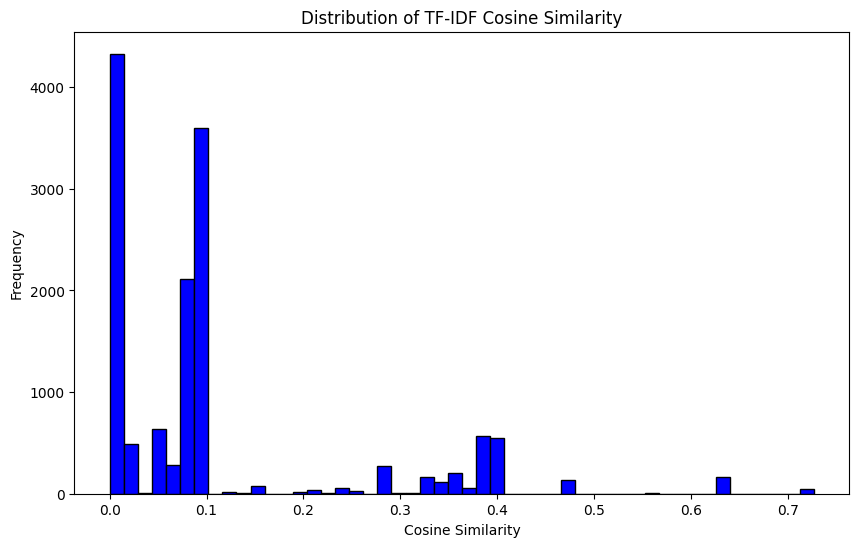

In [101]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(final_df['cosine_similarity_tfidf'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of TF-IDF Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig('TF-IDF Cosine Similarity.png')  
plt.show()


### Word2Vec Cosine Similarity
Word2Vec embeddings capture semantic meaning and are useful for comparing text based on word similarities.

In [82]:
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming you have preprocessed your text into tokens
# If not, you'll need to tokenize your text first

# Tokenize the text into words
final_df['Claim_Tokens'] = final_df['Mapped_Claim'].apply(lambda x: x.split())
final_df['Topic_Tokens'] = final_df['Mapped_Topic'].apply(lambda x: x.split())

# Train a Word2Vec model on the combined data
model = Word2Vec(sentences=final_df['Claim_Tokens'].tolist() + final_df['Topic_Tokens'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Function to calculate average Word2Vec vector for a list of tokens
def avg_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Calculate the average Word2Vec vectors
final_df['Claim_Vector'] = final_df['Claim_Tokens'].apply(lambda x: avg_word2vec(x, model))
final_df['Topic_Vector'] = final_df['Topic_Tokens'].apply(lambda x: avg_word2vec(x, model))

# Calculate cosine similarity between the vectors
cos_sim_word2vec = [cosine_similarity([claim], [topic])[0][0] for claim, topic in zip(final_df['Claim_Vector'], final_df['Topic_Vector'])]

# Add the cosine similarity to the DataFrame
final_df['cosine_similarity_word2vec'] = cos_sim_word2vec

# Display the DataFrame
print(final_df[['Mapped_Claim', 'Mapped_Topic', 'cosine_similarity_word2vec']].head())


                                         Mapped_Claim  \
41                     It is natural cycles/variation   
53  Species/plants/reefs are not showing climate i...   
65        Clean energy technology/biofuels won’t work   
81  Climate policies (mitigation or adaptation) ar...   
82        Clean energy technology/biofuels won’t work   

                                  Mapped_Topic  cosine_similarity_word2vec  
41   Extreme Weather Events and Climate Change                    0.259151  
53          Sea Level Rise and Oceanic Changes                    0.088050  
65  Energy Sources and Their Impact on Climate                    0.195834  
81        Carbon Emissions and Economic Policy                    0.262955  
82  Energy Sources and Their Impact on Climate                    0.195834  


In [83]:
final_df

,pub_text,text_denoised,Mapped_Claim,Mapped_Topic,cosine_similarity_tfidf,Claim_Tokens,Topic_Tokens,Claim_Vector,Topic_Vector,cosine_similarity_word2vec
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,It is natural cycles/variation,Extreme Weather Events and Climate Change,0.000000,"[It, is, natural, cycles/variation]","[Extreme, Weather, Events, and, Climate, Change]","[-0.50655895, 0.2176955, -0.5800392, -0.660219...","[0.073013954, 0.21466284, 0.36415133, -0.29132...",0.259151
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,Species/plants/reefs are not showing climate i...,Sea Level Rise and Oceanic Changes,0.000000,"[Species/plants/reefs, are, not, showing, clim...","[Sea, Level, Rise, and, Oceanic, Changes]","[0.022851309, 0.36368734, -0.16914174, -0.2824...","[-0.12211919, 0.66954356, 0.35734522, -0.55610...",0.088050
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480,"[Clean, energy, technology/biofuels, won’t, work]","[Energy, Sources, and, Their, Impact, on, Clim...","[0.10888536, 0.117719874, -0.32141152, -0.4730...","[0.5221472, 0.07730866, 0.72005546, 0.19813968...",0.195834
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,Climate policies (mitigation or adaptation) ar...,Carbon Emissions and Economic Policy,0.000000,"[Climate, policies, (mitigation, or, adaptatio...","[Carbon, Emissions, and, Economic, Policy]","[-0.09545793, -0.15720941, 0.83588755, 0.68318...","[0.28185147, 0.040889192, -0.0614265, -0.15705...",0.262955
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480,"[Clean, energy, technology/biofuels, won’t, work]","[Energy, Sources, and, Their, Impact, on, Clim...","[0.10888536, 0.117719874, -0.32141152, -0.4730...","[0.5221472, 0.07730866, 0.72005546, 0.19813968...",0.195834
...,...,...,...,...,...,...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855,"[Climate, movement, is, unreliable/alarmist/co...","[Scientific, Research, and, Climate, Change, P...","[-0.15861362, 0.2600336, -0.16481815, -0.20310...","[0.28740218, 0.036140542, 0.75815624, -0.00369...",0.543125
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,Climate movement is unreliable/alarmist/corrupt,Climate Sensitivity and Feedback Mechanisms,0.058747,"[Climate, movement, is, unreliable/alarmist/co...","[Climate, Sensitivity, and, Feedback, Mechanisms]","[-0.15861362, 0.2600336, -0.16481815, -0.20310...","[0.18206759, 0.13577935, -0.15498734, -0.22802...",0.604104
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855,"[Climate, movement, is, unreliable/alarmist/co...","[Scientific, Research, and, Climate, Change, P...","[-0.15861362, 0.2600336, -0.16481815, -0.20310...","[0.28740218, 0.036140542, 0.75815624, -0.00369...",0.543125
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,It is natural cycles/variation,Solar Influence on Climate and Natural Variabi...,0.380816,"[It, is, natural, cycles/variation]","[Solar, Influence, on, Climate, and, Natural, ...","[-0.50655895, 0.2176955, -0.5800392, -0.660219...","[0.15252621, 0.045708474, 0.34521595, 0.018011...",0.107462


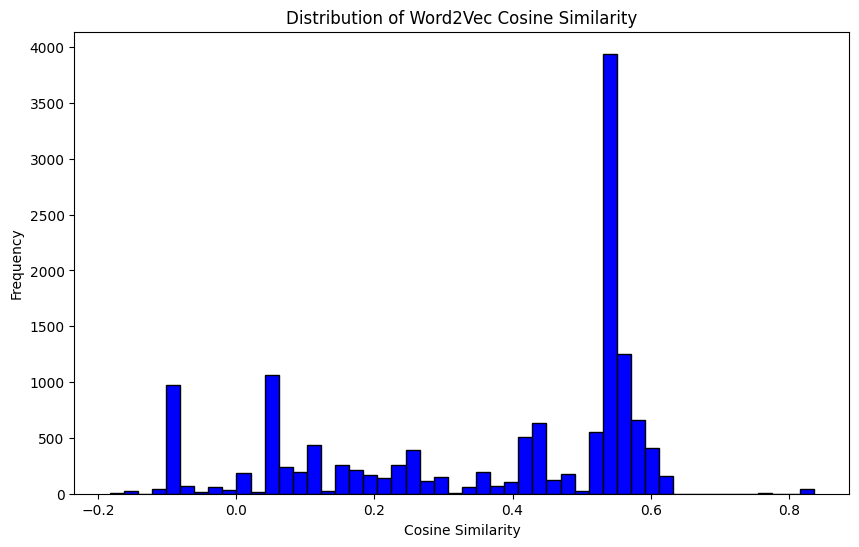

In [102]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(final_df['cosine_similarity_word2vec'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Word2Vec Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig('Word2Vec Cosine Similarity.png')  
plt.show()


### BERT Cosine Similarity
BERT (Bidirectional Encoder Representations from Transformers) embeddings provide context-aware word representations and can be used to compute similarity.

In [86]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings and flatten them to 2D
def get_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    # Flatten to 2D by taking the mean of the last hidden state across the tokens
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# Apply BERT embeddings to both columns
final_df['Claim_BERT'] = final_df['Mapped_Claim'].apply(lambda x: get_bert_embeddings(x, tokenizer, model))
final_df['Topic_BERT'] = final_df['Mapped_Topic'].apply(lambda x: get_bert_embeddings(x, tokenizer, model))

# Calculate cosine similarity between the flattened BERT embeddings
cos_sim_bert = [cosine_similarity([claim], [topic])[0][0] for claim, topic in zip(final_df['Claim_BERT'], final_df['Topic_BERT'])]

# Add the cosine similarity to the DataFrame
final_df['cosine_similarity_bert'] = cos_sim_bert

# Display the DataFrame
print(final_df[['Mapped_Claim', 'Mapped_Topic', 'cosine_similarity_bert']].head())

                                         Mapped_Claim  \
41                     It is natural cycles/variation   
53  Species/plants/reefs are not showing climate i...   
65        Clean energy technology/biofuels won’t work   
81  Climate policies (mitigation or adaptation) ar...   
82        Clean energy technology/biofuels won’t work   

                                  Mapped_Topic  cosine_similarity_bert  
41   Extreme Weather Events and Climate Change                0.481253  
53          Sea Level Rise and Oceanic Changes                0.692389  
65  Energy Sources and Their Impact on Climate                0.594846  
81        Carbon Emissions and Economic Policy                0.713425  
82  Energy Sources and Their Impact on Climate                0.594846  


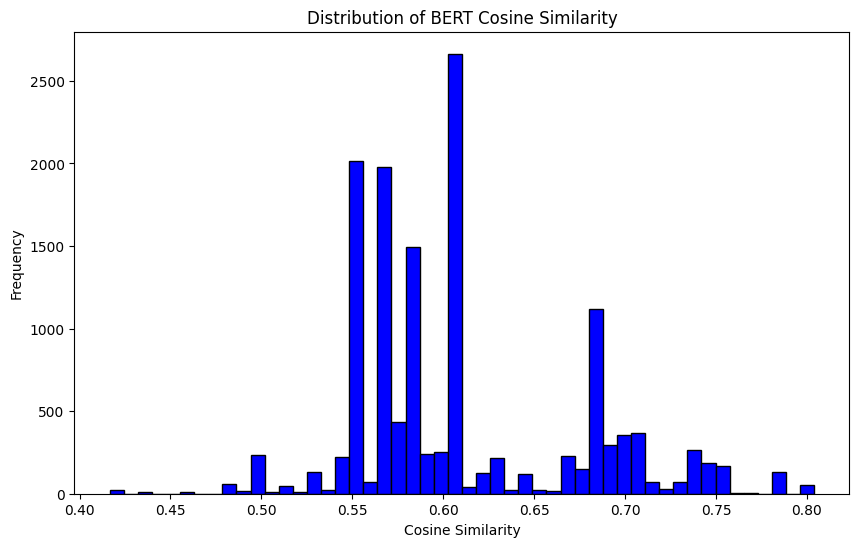

In [103]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(final_df['cosine_similarity_bert'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of BERT Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig('BERT Cosine Similarity.png')  
plt.show()


In [88]:
final_df

,pub_text,text_denoised,Mapped_Claim,Mapped_Topic,cosine_similarity_tfidf,Claim_Tokens,Topic_Tokens,Claim_Vector,Topic_Vector,cosine_similarity_word2vec,Claim_BERT,Topic_BERT,cosine_similarity_bert
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,It is natural cycles/variation,Extreme Weather Events and Climate Change,0.000000,"[It, is, natural, cycles/variation]","[Extreme, Weather, Events, and, Climate, Change]","[-0.50655895, 0.2176955, -0.5800392, -0.660219...","[0.073013954, 0.21466284, 0.36415133, -0.29132...",0.259151,"[0.18982148, 0.019257907, 0.3910258, 0.1526283...","[0.1863173, 0.10326139, -0.17494151, 0.1426583...",0.481253
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,Species/plants/reefs are not showing climate i...,Sea Level Rise and Oceanic Changes,0.000000,"[Species/plants/reefs, are, not, showing, clim...","[Sea, Level, Rise, and, Oceanic, Changes]","[0.022851309, 0.36368734, -0.16914174, -0.2824...","[-0.12211919, 0.66954356, 0.35734522, -0.55610...",0.088050,"[-0.023014728, 0.23144448, 0.3092143, 0.228206...","[-0.037006587, 0.014377816, 0.047297657, 0.106...",0.692389
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480,"[Clean, energy, technology/biofuels, won’t, work]","[Energy, Sources, and, Their, Impact, on, Clim...","[0.10888536, 0.117719874, -0.32141152, -0.4730...","[0.5221472, 0.07730866, 0.72005546, 0.19813968...",0.195834,"[0.5136951, -0.19995509, 0.4496757, 0.5210955,...","[0.27124125, 0.34438983, -0.39940917, 0.336102...",0.594846
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,Climate policies (mitigation or adaptation) ar...,Carbon Emissions and Economic Policy,0.000000,"[Climate, policies, (mitigation, or, adaptatio...","[Carbon, Emissions, and, Economic, Policy]","[-0.09545793, -0.15720941, 0.83588755, 0.68318...","[0.28185147, 0.040889192, -0.0614265, -0.15705...",0.262955,"[-0.09010874, 0.07946234, -0.05993199, 0.32191...","[-0.069710135, 0.15711896, -0.34456158, 0.4342...",0.713425
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480,"[Clean, energy, technology/biofuels, won’t, work]","[Energy, Sources, and, Their, Impact, on, Clim...","[0.10888536, 0.117719874, -0.32141152, -0.4730...","[0.5221472, 0.07730866, 0.72005546, 0.19813968...",0.195834,"[0.5136951, -0.19995509, 0.4496757, 0.5210955,...","[0.27124125, 0.34438983, -0.39940917, 0.336102...",0.594846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855,"[Climate, movement, is, unreliable/alarmist/co...","[Scientific, Research, and, Climate, Change, P...","[-0.15861362, 0.2600336, -0.16481815, -0.20310...","[0.28740218, 0.036140542, 0.75815624, -0.00369...",0.543125,"[0.067201264, -0.12551893, 0.12499606, 0.15562...","[-0.22185183, 0.004445513, -0.56359285, -0.248...",0.586509
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,Climate movement is unreliable/alarmist/corrupt,Climate Sensitivity and Feedback Mechanisms,0.058747,"[Climate, movement, is, unreliable/alarmist/co...","[Climate, Sensitivity, and, Feedback, Mechanisms]","[-0.15861362, 0.2600336, -0.16481815, -0.20310...","[0.18206759, 0.13577935, -0.15498734, -0.22802...",0.604104,"[0.067201264, -0.12551893, 0.12499606, 0.15562...","[0.050137874, 0.06953394, -0.3238707, 0.304840...",0.621642
51331,you are like a rude version of a ~~global warm...,like rude

In [89]:
final_df.columns

Index(['pub_text', 'text_denoised', 'Mapped_Claim', 'Mapped_Topic',
       'cosine_similarity_tfidf', 'Claim_Tokens', 'Topic_Tokens',
       'Claim_Vector', 'Topic_Vector', 'cosine_similarity_word2vec',
       'Claim_BERT', 'Topic_BERT', 'cosine_similarity_bert'],
      dtype='object')

In [90]:
df_new = final_df.drop(['Claim_Tokens', 'Topic_Tokens','Claim_Vector', 'Topic_Vector','Claim_BERT', 'Topic_BERT'], axis=1)
df_new

,pub_text,text_denoised,Mapped_Claim,Mapped_Topic,cosine_similarity_tfidf,cosine_similarity_word2vec,cosine_similarity_bert
41,Because the climate is also effected by natura...,climate also effected natural effect like sola...,It is natural cycles/variation,Extreme Weather Events and Climate Change,0.000000,0.259151,0.481253
53,I was reading an article earlier about a team ...,reading article earlier team australia able sp...,Species/plants/reefs are not showing climate i...,Sea Level Rise and Oceanic Changes,0.000000,0.088050,0.692389
65,"Renewables are a mix, wind remains on par or b...",renewables mix wind remains par nuclear data p...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480,0.195834,0.594846
81,&gt; economic growth has been decoupled from r...,gt economic growth decoupled rising carbon emi...,Climate policies (mitigation or adaptation) ar...,Carbon Emissions and Economic Policy,0.000000,0.262955,0.713425
82,Windfarms and solar are the most effective ove...,windfarms solar effective large area case spac...,Clean energy technology/biofuels won’t work,Energy Sources and Their Impact on Climate,0.344480,0.195834,0.594846
...,...,...,...,...,...,...,...
51324,while the term climate change was always arrou...,term climate change always arround think find ...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855,0.543125,0.586509
51329,&gt; What part of the article do you think he ...,gt part article think james delingpole doesnt ...,Climate movement is unreliable/alarmist/corrupt,Climate Sensitivity and Feedback Mechanisms,0.058747,0.604104,0.621642
51331,you are like a rude version of a ~~global warm...,like rude version global warmingclimate change...,Climate movement is unreliable/alarmist/corrupt,Scientific Research and Climate Change Publica...,0.075855,0.543125,0.586509
51333,&gt;Kulke writes that not only is the CO2-scie...,gtkulke writes coscience explaining climate ch...,It is natural cycles/variation,Solar Influence on Climate and Natural Variabi...,0.380816,0.107462,0.566227


In [91]:
df_new.to_csv('cosine similarity.csv', index=True)

### Basic Statistical Comparison

In [95]:
# Display basic statistics
print(final_df[['cosine_similarity_tfidf', 'cosine_similarity_word2vec', 'cosine_similarity_bert']].describe())

       cosine_similarity_tfidf  cosine_similarity_word2vec  \
count             13991.000000                13991.000000   
mean                  0.107291                    0.365789   
std                   0.139011                    0.231075   
min                   0.000000                   -0.182873   
25%                   0.000000                    0.160946   
50%                   0.075855                    0.520900   
75%                   0.090567                    0.543125   
max                   0.727078                    0.836365   

       cosine_similarity_bert  
count            13991.000000  
mean                 0.609926  
std                  0.063142  
min                  0.416528  
25%                  0.566265  
50%                  0.591820  
75%                  0.661911  
max                  0.803995  


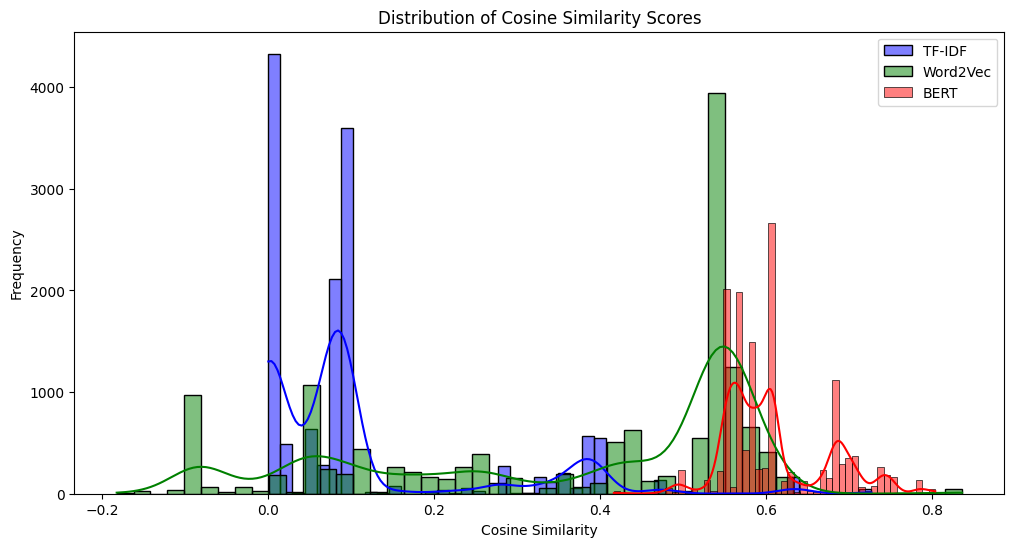

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(final_df['cosine_similarity_tfidf'], bins=50, color='blue', label='TF-IDF', kde=True)
sns.histplot(final_df['cosine_similarity_word2vec'], bins=50, color='green', label='Word2Vec', kde=True)
sns.histplot(final_df['cosine_similarity_bert'], bins=50, color='red', label='BERT', kde=True)
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Distribution of cosine similarity scores for each technique.png')  
plt.show()

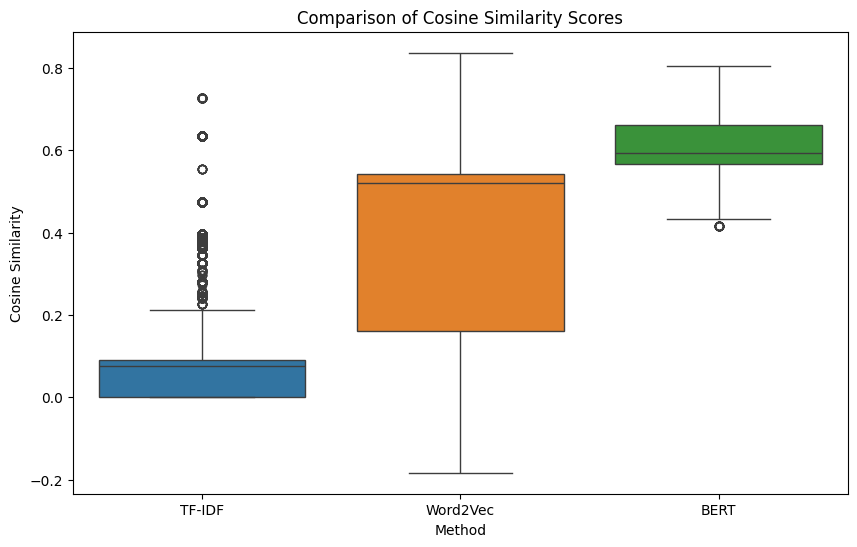

In [98]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df[['cosine_similarity_tfidf', 'cosine_similarity_word2vec', 'cosine_similarity_bert']])
plt.title('Comparison of Cosine Similarity Scores')
plt.xlabel('Method')
plt.ylabel('Cosine Similarity')
plt.xticks([0, 1, 2], ['TF-IDF', 'Word2Vec', 'BERT'])
plt.show()


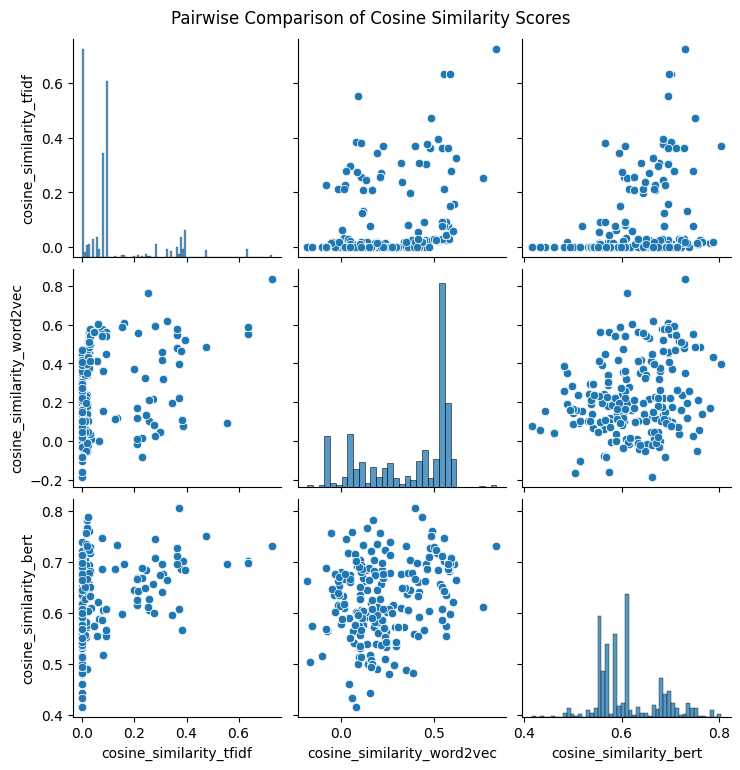

In [99]:
sns.pairplot(final_df[['cosine_similarity_tfidf', 'cosine_similarity_word2vec', 'cosine_similarity_bert']])
plt.suptitle('Pairwise Comparison of Cosine Similarity Scores', y=1.02)
plt.show()


In [105]:
# Calculate the percentage of rows with cosine_similarity_bert > 0.5
rows_above_threshold = final_df[final_df['cosine_similarity_bert'] > 0.5]
percentage_above_threshold = (len(rows_above_threshold) / len(final_df)) * 100

percentage_above_threshold


97.51983417911515

### Approximately 97.52% of the rows have a cosine similarity (BERT) score greater than 0.5.

#### I have grouped the dataframe by the "Mapped_Claim" column and counted the number of rows in each group.

In [128]:
import pandas as pd

# Group the dataframe by the 'Mapped_Claim' column and count the number of rows in each group
grouped_df = final_df.groupby('Mapped_Claim').size().reset_index(name='row_count')

# Display the grouped dataframe
grouped_df


,Mapped_Claim,row_count
0,CO2 is beneficial/not a pollutant,85
1,Clean energy technology/biofuels won’t work,155
2,Climate has not warmed/changed over the last (...,134
3,Climate movement is unreliable/alarmist/corrupt,8966
4,Climate policies (mitigation or adaptation) ar...,558
5,Climate policies are effective/flawed,54
6,Climate sensitivity is low/negative feedbacks ...,91
7,Climate-related science is unreliable/uncertai...,1832
8,Extreme weather is not increasing/has happened...,201
9,Ice/permafrost/snow cover is not melting,534


In [127]:
# For each group, calculate the percentage of rows with cosine_similarity_bert > 0.5
grouped_above_threshold = final_df[final_df['cosine_similarity_bert'] > 0.5].groupby('Mapped_Claim').size().reset_index(name='rows_above_threshold')
grouped_total = final_df.groupby('Mapped_Claim').size().reset_index(name='total_rows')

# Merge the two dataframes on 'Mapped_Claim'
merged_df = pd.merge(grouped_total, grouped_above_threshold, on='Mapped_Claim', how='left')

# Fill NaN values with 0 (for groups that don't have any rows above the threshold)
merged_df['rows_above_threshold'].fillna(0, inplace=True)

# Calculate the percentage
merged_df['percentage_above_threshold'] = (merged_df['rows_above_threshold'] / merged_df['total_rows']) * 100

# Display the result in a standard way
merged_df[['Mapped_Claim', 'percentage_above_threshold']]


,Mapped_Claim,percentage_above_threshold
0,CO2 is beneficial/not a pollutant,100.000000
1,Clean energy technology/biofuels won’t work,99.354839
2,Climate has not warmed/changed over the last (...,99.253731
3,Climate movement is unreliable/alarmist/corrupt,100.000000
4,Climate policies (mitigation or adaptation) ar...,100.000000
5,Climate policies are effective/flawed,100.000000
6,Climate sensitivity is low/negative feedbacks ...,100.000000
7,Climate-related science is unreliable/uncertai...,100.000000
8,Extreme weather is not increasing/has happened...,100.000000
9,Ice/permafrost/snow cover is not melting,97.565543


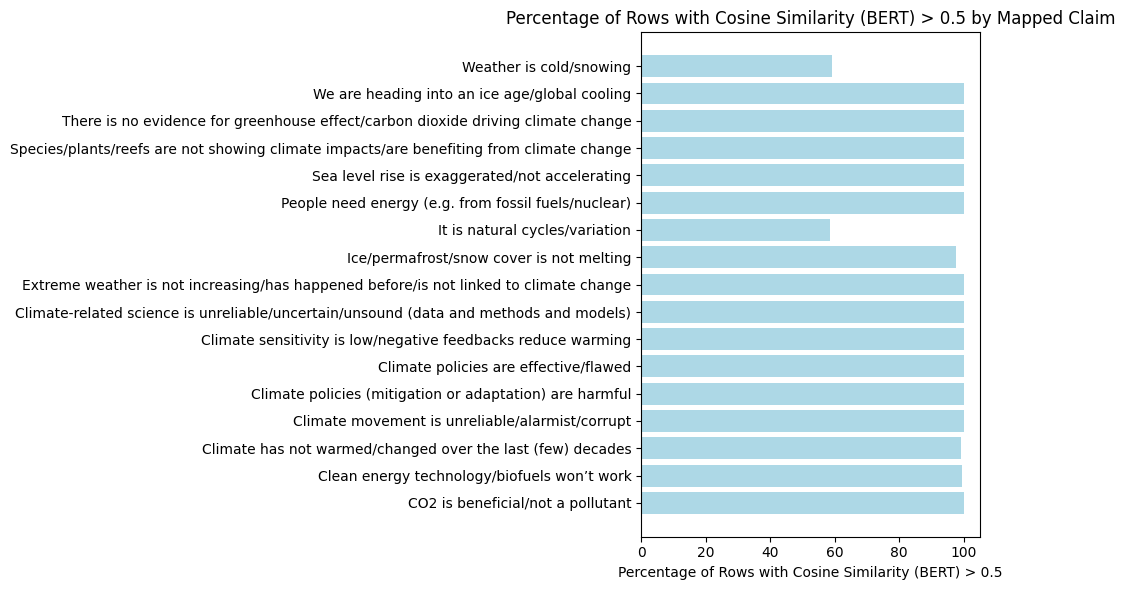

In [130]:
# Replot the graph using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(merged_df['Mapped_Claim'], merged_df['percentage_above_threshold'], color='lightblue')
plt.xlabel('Percentage of Rows with Cosine Similarity (BERT) > 0.5')
plt.title('Percentage of Rows with Cosine Similarity (BERT) > 0.5 by Mapped Claim')
plt.tight_layout()

plt.savefig('Percentage of Rows with Cosine Similarity (BERT) > 0.5 by Mapped Claim.png')  
plt.show()
